## Import Libraries ##

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.2MB/s 
     |████████████████████████████████| 901kB 45.1MB/s 
     |████████████████████████████████| 3.3MB 51.6MB/s 


In [ ]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from scipy.special import softmax
import matplotlib.pyplot as plt

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Preparing the Dataset ##
Dataset balancing later lah

In [ ]:
csv_raw = pd.read_csv('finegrained_train_data.csv').drop("Unnamed: 0", axis=1).drop("movie", axis=1)
csv_raw['genre'] = csv_raw['genre'].apply(lambda x: list(ast.literal_eval(x)))
csv_raw

,genre,text
0,[disaster],"Come on, Hicks. This is for your all-time best..."
1,[disaster],yours? I don't know which way you're facing! I...
2,[disaster],and I would appreciate not being cut out of it...
3,[disaster],haven't seen last night's seismographs. I have...
4,[disaster],have firearms? -No. -Of course not! Fireworks?...
...,...,...
3328,[scifi],it the alien? It was Christopher. (BREATHING H...
3329,[scifi],GRUNTING) (ALL CLAMORING) Grab him. Get off me...
3330,[scifi],Shut up. CREW MEMBERS: Shut up. Shut up. Shut ...
3331,[scifi],released. (DRAMATIC MUSIC PLAYING) (SELA AND Z...


In [ ]:
genres = csv_raw['genre'].apply(pd.Series).stack().unique()
genres

array(['disaster', 'scifi', 'adventure', 'comedy', 'action', 'horror',
       'romance', 'spy', 'martialarts'], dtype=object)

In [ ]:
csv_raw['genre'] = csv_raw['genre'].apply(lambda x: [1 if g in x else 0 for g in genres])
csv_raw

,genre,text
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0]","Come on, Hicks. This is for your all-time best..."
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",yours? I don't know which way you're facing! I...
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",and I would appreciate not being cut out of it...
3,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",haven't seen last night's seismographs. I have...
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",have firearms? -No. -Of course not! Fireworks?...
...,...,...
3328,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",it the alien? It was Christopher. (BREATHING H...
3329,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",GRUNTING) (ALL CLAMORING) Grab him. Get off me...
3330,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",Shut up. CREW MEMBERS: Shut up. Shut up. Shut ...
3331,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",released. (DRAMATIC MUSIC PLAYING) (SELA AND Z...


In [ ]:
total = np.zeros((1, len(genres)))

for idx, row in csv_raw.iterrows():
    total = total + np.array(row['genre'])
    
total

array([[ 317.,  854.,  433., 1480.,  979.,  497.,  521.,  309.,  237.]])

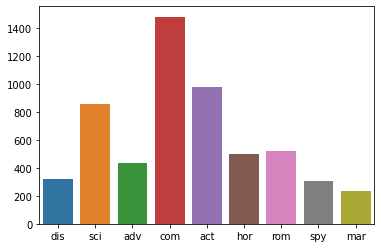

In [ ]:
sns.barplot(x=[g[:3] for g in genres], y=total.tolist()[0])

## BERT Settings ##

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 8e-06

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.genre
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
        
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8

train_dataset = csv_raw.sample(frac=train_size, random_state=0)
test_dataset = csv_raw.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(csv_raw.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3333, 2)
TRAIN Dataset: (2666, 2)
TEST Dataset: (667, 2)


In [ ]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Building the Model ##

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, len(genres))
        
    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output
    
model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

## Training ##

In [ ]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
eval_every = len(training_loader) // 10

running_loss = 0.0
valid_running_loss = 0.0
global_step = 0
train_loss_list = []
valid_loss_list = []
global_steps_list = []

best_valid_loss = float("Inf")

model.train()
for epoch in range(EPOCHS):
    for i, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        global_step += 1
        
        if global_step % eval_every == 0:
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(testing_loader, 0):
                    ids = data['ids'].to(device, dtype=torch.long)
                    mask = data['mask'].to(device, dtype=torch.long)
                    token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                    targets = data['targets'].to(device, dtype=torch.float)
                    
                    outputs = model(ids, mask, token_type_ids)
                    loss = loss_fn(outputs, targets)
                    
                    valid_running_loss += loss.item()
                    
            average_train_loss = running_loss / eval_every
            average_valid_loss = valid_running_loss / len(testing_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            global_steps_list.append(global_step)
            
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()
            
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(epoch+1, EPOCHS, global_step, EPOCHS*len(training_loader),average_train_loss, average_valid_loss))

            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint('model.pt', model, best_valid_loss)
                save_metrics('metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
            
save_metrics('metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
print("Finished testing your patience!")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch [1/10], Step [66/6670], Train Loss: 0.5711, Valid Loss: 0.4830
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [132/6670], Train Loss: 0.4670, Valid Loss: 0.4519
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [198/6670], Train Loss: 0.4405, Valid Loss: 0.4360
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [264/6670], Train Loss: 0.4392, Valid Loss: 0.4202
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [330/6670], Train Loss: 0.4228, Valid Loss: 0.4231
Epoch [1/10], Step [396/6670], Train Loss: 0.4185, Valid Loss: 0.3906
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [462/6670], Train Loss: 0.3888, Valid Loss: 0.3786
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [528/6670], Train Loss: 0.3675, Valid Loss: 0.3645
Model saved to ==> model.pt
Model saved to ==> metrics.pt
Epoch [1/10], Step [594/6670], Trai

In [ ]:
if best_valid_loss > average_valid_loss:
    best_valid_loss = average_valid_loss
    save_checkpoint('model.pt', model, best_valid_loss)
    save_metrics('metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

Model loaded from <== metrics.pt


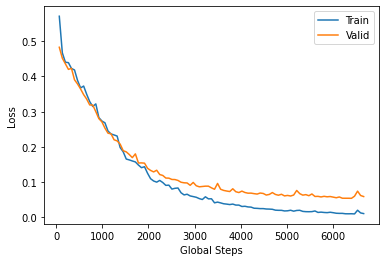

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
def validation(vmodel):
    vmodel.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = vmodel(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(model)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy Score = 0.9010494752623688
F1 Score (Micro) = 0.9529411764705883
F1 Score (Macro) = 0.9510977168780721


In [ ]:
best_model = BERTClass().to(device)
load_checkpoint('model.pt', best_model)

outputs, targets = validation(best_model)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== model.pt


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy Score = 0.904047976011994
F1 Score (Micro) = 0.9569551427276847
F1 Score (Macro) = 0.955344559224381
